<a href="https://colab.research.google.com/github/rustadadam/PF-GAP/blob/main/Time_series_Proximities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Proximities file

The goal here is to make it easy to put a time-series through any of these models (and static data) and get the resulting proximites so we can speed up testing.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_/YOUR_REPOSITORY_NAME/blob/main/YOUR_NOTEBOOK_NAME.ipynb)

In [1]:
# Necessary downloads
%%capture
!pip install aeon
!pip install git+https://github.com/jakerhodes/RF-GAP-Python
!pip install tslearn
!pip install shapedtw


# Download files from my repository
!wget https://raw.githubusercontent.com/rustadadam/PF-GAP/main/FreshPrince/FreshPrince.py -O FreshPrince.py
!wget https://raw.githubusercontent.com/rustadadam/PF-GAP/main/helpers.py -O helpers.py
!wget https://raw.githubusercontent.com/rustadadam/PF-GAP/main/QGAP/qgap.py -O Quant.py
!wget https://raw.githubusercontent.com/rustadadam/PF-GAP/main/RDST/rdst.py -O RDST.py
!wget https://raw.githubusercontent.com/rustadadam/PF-GAP/main/RFGAP_Rocket/RFGAP_Rocket.py -O RFGAP_Rocket.py
!wget https://raw.githubusercontent.com/rustadadam/PF-GAP/main/Redcomets/Redcomets.py -O Redcomets.py
!wget https://raw.githubusercontent.com/rustadadam/PF-GAP/main/independent_distance/distance_helpers.py -O distance_helpers.py
!wget https://raw.githubusercontent.com/rustadadam/PF-GAP//main/Pipeline/functions.py -O functions.py

In [15]:
# Import necessary files
import aeon
from FreshPrince import FreshPRINCE_GAP
import helpers
from Quant import QGAP
from RDST import RDST_GAP
from RFGAP_Rocket import RFGAP_Rocket
from Redcomets import REDCOMETS
from distance_helpers import *
from functions import *


#Toy Data
from aeon.datasets import load_gunpoint

#Other utility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS

In [25]:
# Load Data
Xtrain, Ytrain = load_gunpoint(split="TRAIN")
Xtest, Ytest = load_gunpoint(split="TEST")

Ytrain = Ytrain.astype(int)
Ytest = Ytest.astype(int)

#For demonstration, lets generate random static variables
Xstatic = np.random.rand(Xtrain.shape[0], 45)
Xstatic_test = np.random.rand(Xtest.shape[0], 45)

# ---------- Functions for plotting ------------
def symmetrize_matrix(name, mat):

    if name.lower() in ['cosine', "dtw", "soft-dtw"]:

        # Normalize to [0, 1]
        mat = (mat - mat.min()) / (mat.max() - mat.min()) * 0.1
        return  0.1 - mat
    else:
        # Set the diagonal entries to 1
        np.fill_diagonal(mat, 1.0)

    return (mat + mat.T) / 2

# Function to plot MDS scatter

def mds_scatter(dist_matrix, labels, title="MDS Scatter Plot"):
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, metric = False)
    coords = mds.fit_transform(1 - dist_matrix)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(coords[:, 0], coords[:, 1], c=labels, s=30)
    plt.title(title)
    plt.xlabel("MDS1")
    plt.ylabel("MDS2")
    plt.colorbar(scatter, label="Class Label")
    plt.grid(True)
    plt.show()

# Function to plot UMAP scatter
def umap_scatter(dist_matrix, labels, title="UMAP Scatter Plot"):
    import umap
    reducer = umap.UMAP(n_components=2, metric="precomputed", random_state=42)
    coords = reducer.fit_transform(1 - dist_matrix)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(coords[:, 0], coords[:, 1], c=labels,  s=30)
    plt.title(title)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.colorbar(scatter, label="Class Label")
    plt.grid(True)
    plt.show()

# Function to plot heatmap sorted by class
def heatmap_sorted(dist_matrix, labels, title="Proximity Matrix Heatmap (Sorted by Class)"):
    sort_idx = np.argsort(labels)
    sorted_matrix = dist_matrix[sort_idx][:, sort_idx]
    sorted_labels = labels[sort_idx]
    sorted_matrix = np.clip(sorted_matrix, 0, 0.1)
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_matrix, cmap='viridis', square=True, cbar=True)
    plt.title(title)
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Sample Index (sorted)")

    # Find indices where the class changes
    class_change_indices = np.where(np.diff(sorted_labels) != 0)[0] + 1
    for idx in class_change_indices:
        plt.axvline(idx, color='white', linestyle='--', linewidth=1)
        plt.axhline(idx, color='white', linestyle='--', linewidth=1)

    plt.show()


#Function to call all of the above
def plot_all(name, mat, labels):
  mat = symmetrize_matrix(name, mat)
  print(f"\n---------- {name} -------------")
  print(f"Matrix shape: {mat.shape}")

  mds_scatter(mat, labels, title=f"MDS Scatter Plot: {name}")
  umap_scatter(mat, labels, title=f"UMAP Scatter Plot: {name}")
  heatmap_sorted(mat, labels, title=f"Proximity Matrix Heatmap (Sorted by Class): {name}")

# Building example Pipelines

## Rocket

In [13]:
# First, we need to fit one of the many models we have. For now, I will demonstrate Rocket
rf_rocket = RFGAP_Rocket(prediction_type = "classification",
                         rocket = "Multi",
                         n_kernels=512)
rocket_proximities = data_to_proximities(rf_rocket, Xtrain, Ytrain, Xstatic)
rocket_proximities

array([[0.        , 0.04167953, 0.        , ..., 0.0474506 , 0.01025641,
        0.0399908 ],
       [0.04465975, 0.        , 0.00339421, ..., 0.04432234, 0.01591701,
        0.02897754],
       [0.01949342, 0.0126368 , 0.        , ..., 0.01998126, 0.02644182,
        0.01225649],
       ...,
       [0.04447155, 0.0361002 , 0.03030303, ..., 0.        , 0.00757576,
        0.03955545],
       [0.01189663, 0.00432407, 0.05728748, ..., 0.01127718, 0.        ,
        0.00332901],
       [0.03901488, 0.03601726, 0.0012285 , ..., 0.04223425, 0.0012285 ,
        0.        ]])


---------- Rocket -------------
Matrix shape: (50, 50)


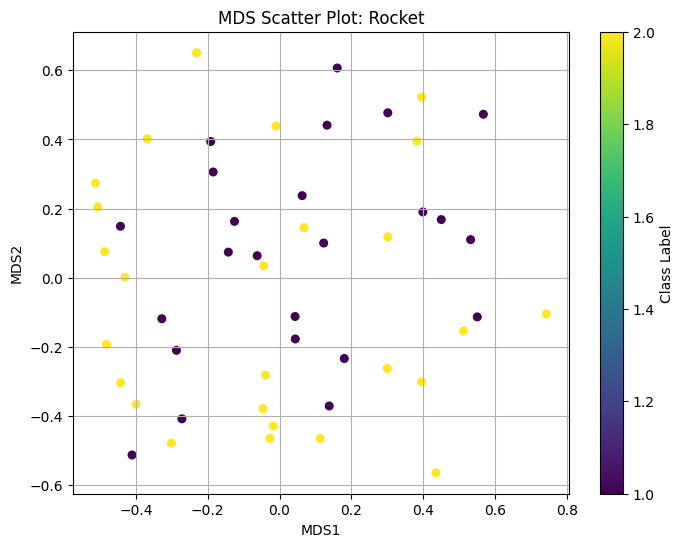

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


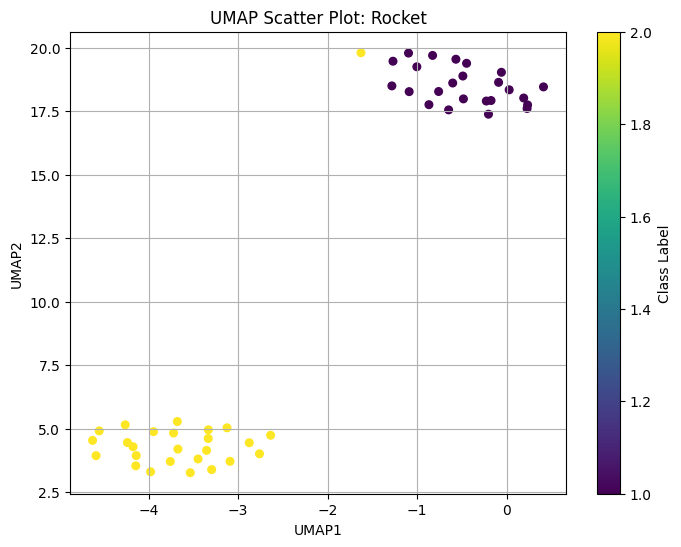

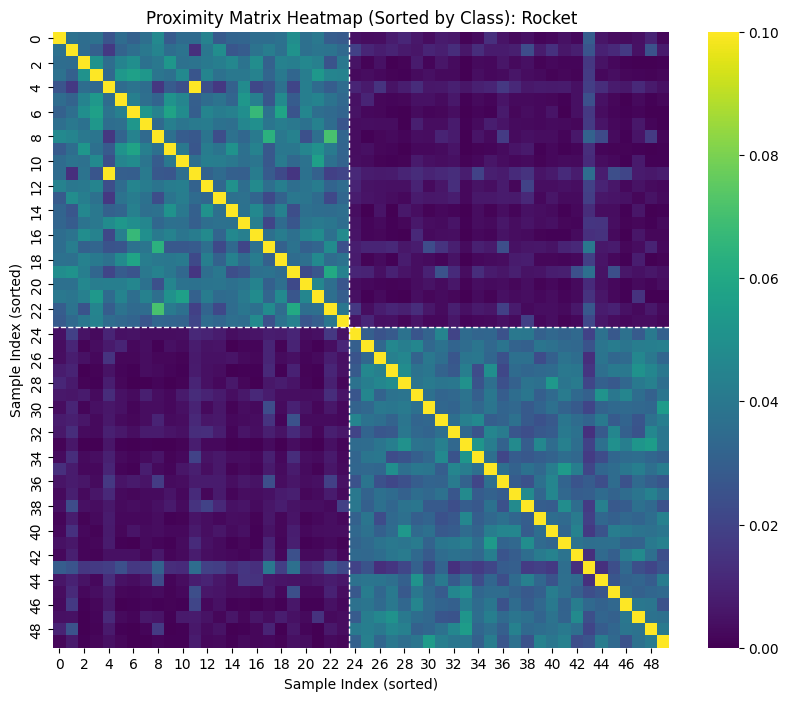

In [26]:
plot_all("Rocket", rocket_proximities, Ytrain)

## QGAP

In [39]:
qgap = QGAP(matrix_type="dense")
qgap_proximities = data_to_proximities(qgap, Xtrain, Ytrain, Xstatic)
qgap_proximities

array([[0.        , 0.05653096, 0.00176056, ..., 0.05302001, 0.01501187,
        0.02444913],
       [0.04072547, 0.        , 0.0021645 , ..., 0.05810452, 0.00974026,
        0.01426212],
       [0.00861938, 0.0186024 , 0.        , ..., 0.0159776 , 0.04192195,
        0.00633944],
       ...,
       [0.03573503, 0.03656835, 0.02430546, ..., 0.        , 0.02538898,
        0.01928307],
       [0.00946552, 0.00907135, 0.04614592, ..., 0.01120127, 0.        ,
        0.00982005],
       [0.03801629, 0.02892056, 0.        , ..., 0.02819333, 0.        ,
        0.        ]])


---------- QGAP -------------
Matrix shape: (50, 50)


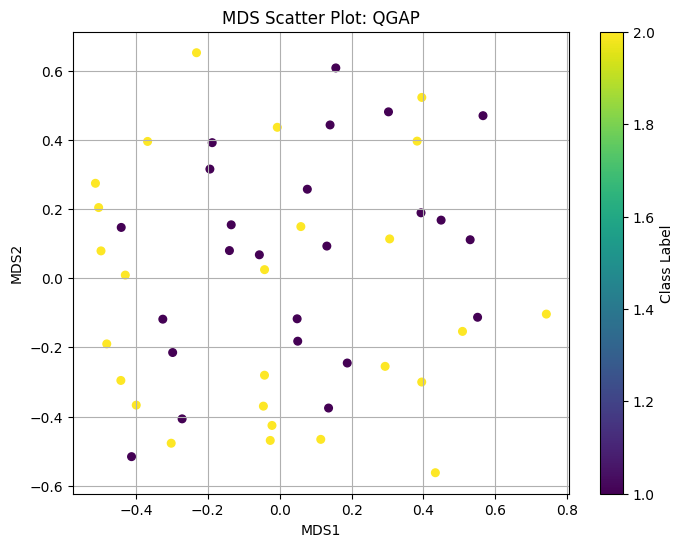

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


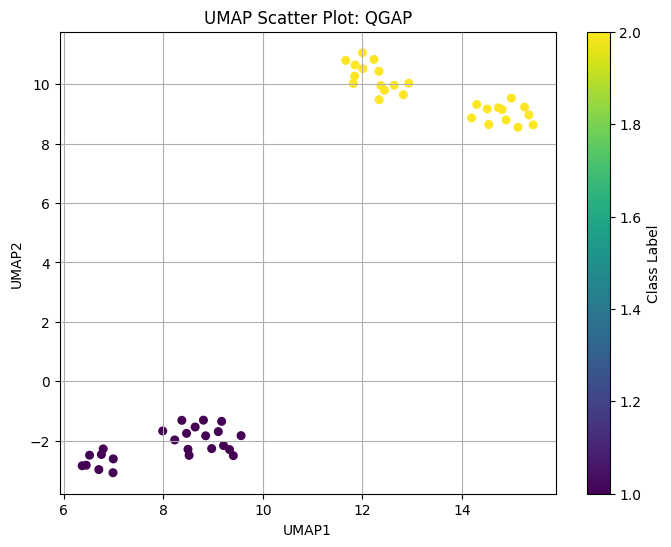

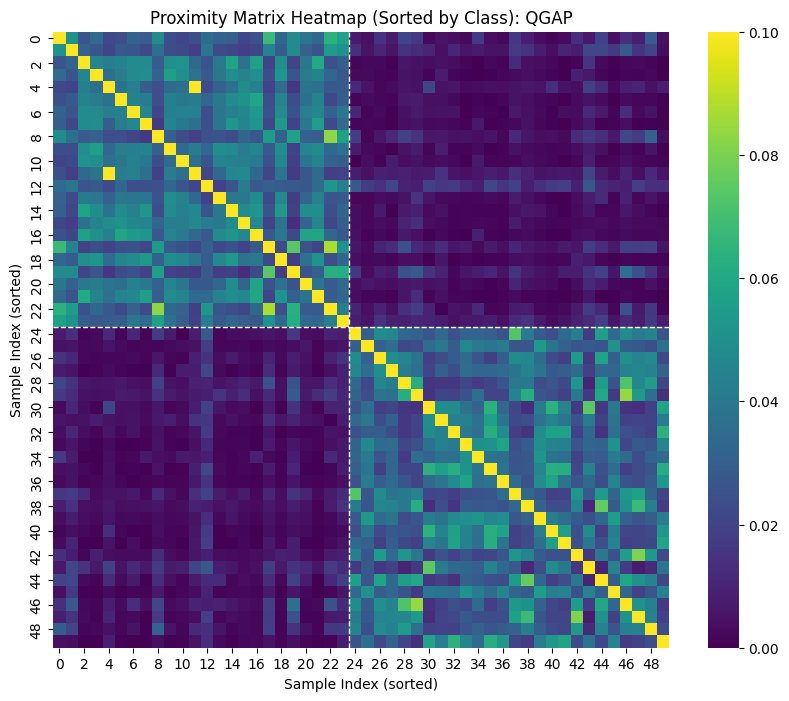

In [40]:
plot_all("QGAP", qgap_proximities, Ytrain)

## Distance Measures
- I use Cosine here, but it can be any

In [ ]:
METRIC = "Cosine"

In [32]:
Xtrain.shape #Note, this needs to be flattened for the following code to work

(50, 1, 150)

In [38]:
Xtrain_flat = Xtrain.reshape(Xtrain.shape[0], -1)
Xtrain_flat.shape # This has to be done because it the implementation can't currently handle multivariate channels
                  # We could change this if we wanted though

(50, 150)

In [36]:
cosine_dist = compute_distance_matrix(Xtrain_flat, metric= METRIC.lower())
cosine_dist

array([[0.        , 0.0716646 , 0.07871945, ..., 0.0904567 , 0.22174556,
        0.48943696],
       [0.0716646 , 0.        , 0.02081551, ..., 0.02592843, 0.05901422,
        0.4958243 ],
       [0.07871945, 0.02081551, 0.        , ..., 0.02734411, 0.05669893,
        0.42053246],
       ...,
       [0.0904567 , 0.02592843, 0.02734411, ..., 0.        , 0.07884793,
        0.50687167],
       [0.22174556, 0.05901422, 0.05669893, ..., 0.07884793, 0.        ,
        0.46383839],
       [0.48943696, 0.4958243 , 0.42053246, ..., 0.50687167, 0.46383839,
        0.        ]])


---------- Cosine -------------
Matrix shape: (50, 50)


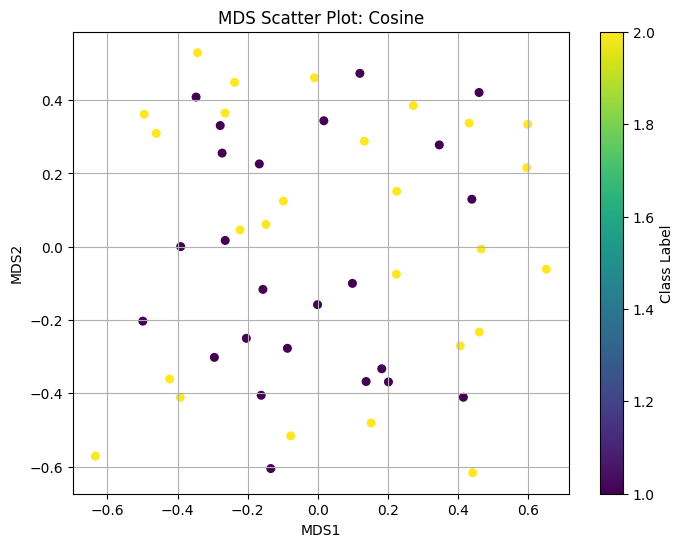

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


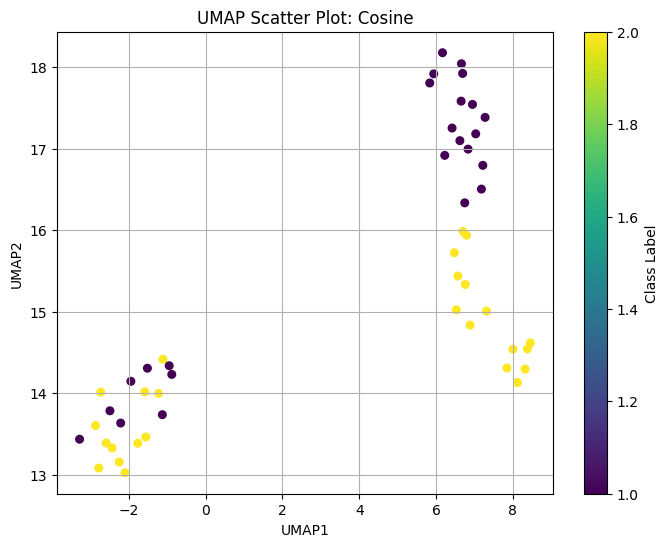

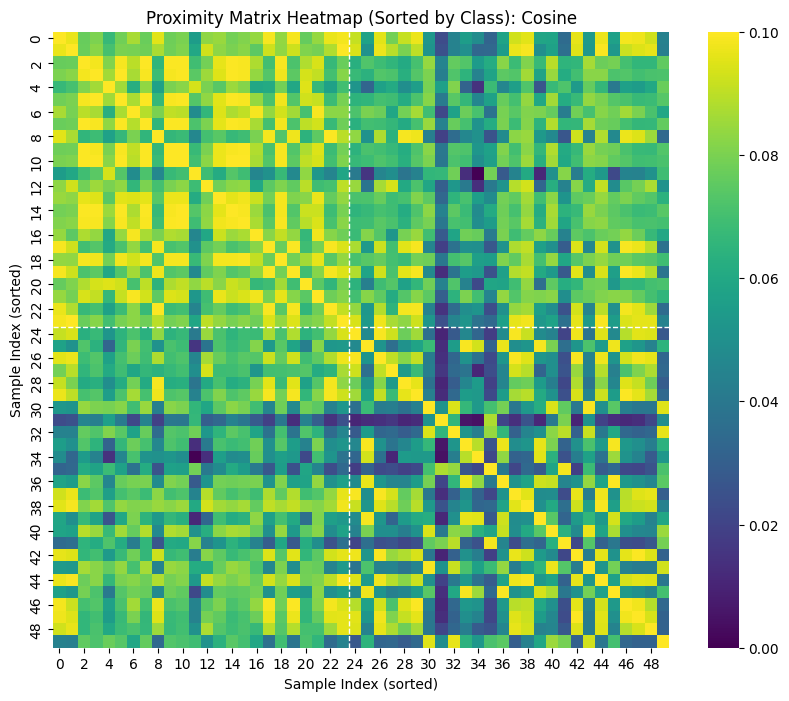

In [37]:
plot_all(METRIC, cosine_dist, Ytrain)